# Линейная регрессия и JAX

In [1]:
import pandas as pd

import jax.numpy as jnp
import jax
import numpy as np

import sklearn
import sklearn.model_selection
import sklearn.datasets

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Загрузим данные `boston housing` - 13 атрибутов и цена дома

In [2]:
dataset = sklearn.datasets.load_boston()

X, y = dataset['data'], dataset['target']
feats = dataset['feature_names']

#X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X = (X - X.mean(axis=0)) / np.sqrt(X.var(axis=0))

pd.DataFrame(X, columns=feats).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501


Разделим тестовую и тренировную выборки

In [3]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)

Сгенериуем случайные значения для параметров линейной регрессии

In [4]:
w = np.random.randn(13)
b = np.random.randn(1)

$$a(X) = x_{1}  w_{1} + \ldots + x_n  w_n + b = x w^T + b $$

Функция `predict` - на вход веса и данные

In [5]:
def predict(w, b, X):
    return X @ w.T + b

Функция потерь (MSE)

In [6]:
@jax.jit
def loss(w, b, X, y_expected):
    predicted = predict(w, b, X)
    return ((y_expected - predicted) ** 2).mean()

Градиент от функции потерь от параметров

In [7]:
grad_loss = jax.jit(jax.grad(loss, argnums=(0, 1)))

Цикл градиентного спуска

In [9]:
train_losses = []
test_losses = []

alpha = 0.01
for i in range(500):    
    w_grad, b_grad = grad_loss(w, b, X_train, y_train)
    
    w -= alpha * w_grad
    b -= alpha * b_grad        
    
    loss_train = loss(w, b, X_train, y_train)
    loss_test = loss(w, b, X_test, y_test)
    
    train_losses.append(loss_train)
    test_losses.append(loss_test)

Графики 

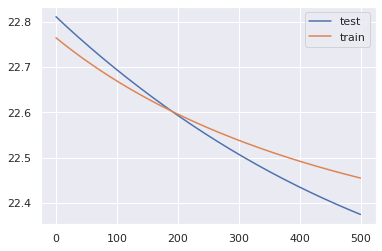

In [10]:
ticks = np.arange(len(train_losses))

plt.plot(ticks, test_losses, label='test')
plt.plot(ticks, train_losses, label='train')

plt.legend()

In [11]:
pd.DataFrame([w], columns=feats)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.769593,1.047757,-0.63097,0.844402,-2.067609,2.25209,-0.320399,-3.583429,1.859369,-0.997597,-2.096129,0.769406,-3.504368


# Линейная регрессия и PyTorch

In [12]:
import torch.nn
import torch

from torchviz import make_dot

Загрузим даные в массивы `NumPy`

In [13]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)

Преобразуем массивы `NumPy` в тензоры `PyTorch`

In [14]:
dtype = torch.get_default_dtype()

t_X_train = torch.tensor(X_train, dtype=dtype)
t_y_train = torch.tensor(y_train, dtype=dtype)

t_X_test = torch.tensor(X_test, dtype=dtype)
t_y_test = torch.tensor(y_test, dtype=dtype)

Сгенерируем случайные значения для `w` и `b`, посчитаем mse для тестовых данных

In [15]:
w = torch.randn(1, 13, requires_grad=True)
b = torch.randn(1, requires_grad=True)

predicted = t_X_train @ w.view(-1, 1) + b
mse = ((predicted - t_y_train) ** 2).mean()

Отобразим граф операций, который используется для вычисления градиента

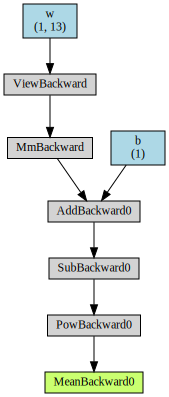

In [16]:
make_dot(mse, {'w': w, 'b': b})

Тривиальный цикл градиентного спуска. Контекстный менеджер `torch.grad()` отменяет построение графа операций внутри - он не нужен при обновлении модели. 

In [17]:
lr = 0.01

for step in range(500):
    predicted = t_X_train @ w.view(-1, 1) + b
    mse = ((predicted - t_y_train) ** 2).mean() 
    
    if (step + 1) % 50 == 0:
        print(f'Train mse {mse.item()}')
    
    mse.backward()    
               
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad        
        
        w.grad.zero_()
        b.grad.zero_()                                                            

Train mse 146.28631591796875
Train mse 88.9519271850586
Train mse 80.91447448730469
Train mse 79.71350860595703
Train mse 79.50830078125
Train mse 79.46217346191406
Train mse 79.44659423828125
Train mse 79.4390640258789
Train mse 79.43453979492188
Train mse 79.43150329589844


Cозданим модель линейной регресси. Класс должен наследоваться от `torch.nn.Module`. В конструкторе все явно-заданные параметры-тензорв должны оборачиваться в `torch.nn.Parameter`  (это позволяет `PyTorch` автоматически определять параметры модели, сохранять их и т.д.). Метод `forward()` - вычисление значений модели. 

In [18]:
class LRModel(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.w = torch.nn.Parameter(torch.randn(1, 13, requires_grad=True))
        self.b = torch.nn.Parameter(torch.randn(1, requires_grad=True))
        
    def forward(self, X):
        predicted = X @ self.w.view(-1, 1) + self.b          
        return predicted.view(-1)

При оптимизации параметров используем специальный класс `SGD` - реализацию стохастического градиентного спуска. Таким образом не нужно больше вручную реализовывать изменение параметров на каждом шаге. 

In [19]:
from torch.optim import SGD

model = LRModel()
mse = torch.nn.MSELoss()

optim = SGD(model.parameters(), lr=0.001)

train_losses = []
test_losses = []

for step in range(1000):
    optim.zero_grad()
    
    predicted = model(t_X_train)
    loss = mse(t_y_train, predicted.view(-1))
    loss.backward()
    optim.step()
    
    if (step + 1) % 10 == 0:
        train_loss = mse(t_y_train, model(t_X_train))
        test_loss = mse(t_y_test, model(t_X_test))
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    

Строим графики

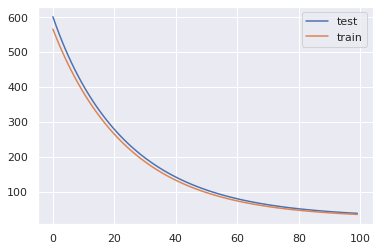

In [20]:
ticks = np.arange(len(train_losses))

plt.plot(ticks, test_losses, label='test')
plt.plot(ticks, train_losses, label='train')

plt.legend()